In [70]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

###### PIMCO GIS GlbInvGrdCrdt E EUR Hdg Acc - ISIN IE00B11XZ434 - Mutual Fund

##### vs

######  iShares iBoxx  Invmt Grade Corp Bd ETF (LQD)

In [3]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib.ticker import FuncFormatter
from pandas_datareader import data as pdr
from time import gmtime, strftime
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)
pd.set_option("display.max_rows", 20)

# Set matplotlib style
plt.style.use('seaborn')

# Set plotly offline
init_notebook_mode(connected=True)

In [72]:
import cufflinks as cf

In [73]:
a = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('A última vez que este script foi executado foi em:', a)

A última vez que este script foi executado foi em: 2017-10-08 02:32:51


In [74]:
#### Functions ####
def compute_drawdowns(dataframe):
    """
    Function to compute drawdowns of a timeseries
    """
    return (dataframe / dataframe.cummax() -1) * 100

In [75]:
# Downloading funds and creating quotes and returns dataframes
Begin = "2007-10-31"
                           
MSid = ['F0GBR06T6F']
Nomes = ['PimcoIG']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

In [76]:
fundos.head()

,PimcoIG
date,
2007-10-31,10.49
2007-11-01,10.51
2007-11-02,10.53
2007-11-05,10.51
2007-11-06,10.49


In [77]:
fundos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2451 entries, 2007-10-31 to 2017-10-06
Data columns (total 1 columns):
PimcoIG    2451 non-null float64
dtypes: float64(1)
memory usage: 38.3 KB


In [78]:
# download quotes
tickers = ['LQD']
Quotes = pd.DataFrame()
Start ='2007-10-31'

for t in tickers:
    Quotes[t] = pdr.get_data_yahoo(t, start=Start)['Adj Close']

In [79]:
Quotes.head()

,LQD
Date,
2007-10-31,70.064919
2007-11-01,70.599983
2007-11-02,70.161850
2007-11-05,70.334442
2007-11-06,69.902954


In [80]:
Quotes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2502 entries, 2007-10-31 to 2017-10-06
Data columns (total 1 columns):
LQD    2502 non-null float64
dtypes: float64(1)
memory usage: 39.1 KB


In [81]:
Quotes_df = Quotes.merge(fundos, left_index = True, right_index = True, how='outer')

In [82]:
Quotes_df.head()

,LQD,PimcoIG
2007-10-31,70.064919,10.49
2007-11-01,70.599983,10.51
2007-11-02,70.161850,10.53
2007-11-05,70.334442,10.51
2007-11-06,69.902954,10.49


In [83]:
Quotes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2502 entries, 2007-10-31 to 2017-10-06
Data columns (total 2 columns):
LQD        2502 non-null float64
PimcoIG    2451 non-null float64
dtypes: float64(2)
memory usage: 58.6 KB


In [84]:
# Reordering the columns
Quotes_df = Quotes_df[['PimcoIG', 'LQD']]

In [85]:
Quotes_df = Quotes_df.fillna(method='ffill')

In [86]:
Quotes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2502 entries, 2007-10-31 to 2017-10-06
Data columns (total 2 columns):
PimcoIG    2502 non-null float64
LQD        2502 non-null float64
dtypes: float64(2)
memory usage: 58.6 KB


In [87]:
#### Returns ####
returns = (Quotes_df / Quotes_df.shift(1)) - 1

In [88]:
#### Normalization to 100 ####
Quotes_df_norm = round((Quotes_df / Quotes_df.iloc[0] * 100), 2)

In [89]:
Quotes_df_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance dos fundos')

In [90]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(Quotes_df_norm), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios', yTitle='Percentagem')

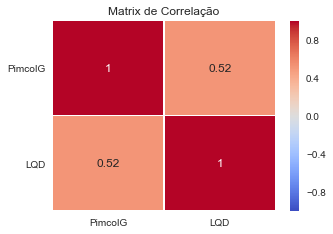

In [91]:
##### New Preturns (to include Portfolio returns) ####
Preturns = (Quotes_df_norm / Quotes_df_norm.shift(1)) - 1

##### Correlation (bonus: Seaborn heatmap)####
Pcorr_matrix = Preturns.corr()
a = -0.5

# Normal heatmap
fig, ax = plt.subplots()
fig.set_size_inches(5, 3.5) # 68%
sns.heatmap(Pcorr_matrix, annot = True, cmap = "coolwarm", linewidths=.2, vmin=-1)
plt.yticks(rotation=360)
plt.title('Matrix de Correlação')
plt.show()

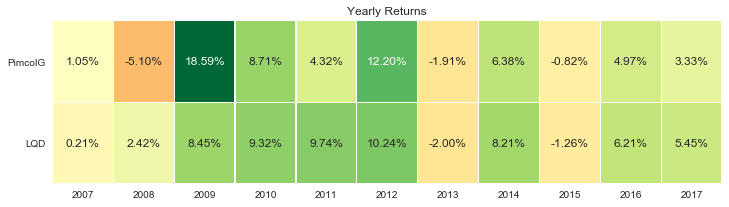

In [93]:
# Resampling to yearly (business year)
yearly_quotes = Quotes_df_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([Quotes_df_norm.iloc[:1], yearly_quotes])

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
returns = yearly_returns.set_index([list(range(2006, 2018))]).drop(2006)

#### Inverter o sentido das rows no dataframe ####
returns = returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(12, 3) # 68%
heatmap = sns.heatmap(returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()